# Emotional Speech Recognition
This notebook will be an audio classification problem and solved with Audio Feature extraction and augmentation, Machine Learning and Deep Learning. 

https://www.kaggle.com/dejolilandry/asvpesdspeech-nonspeech-emotional-utterances

In [1]:
import numpy as np 
import pandas as pd
import os 
import math
import librosa
import torch 
import torchaudio 
import torch.nn as nn 
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
#%matplotlib_inline
import seaborn as sns
import librosa 
import librosa.display

import IPython.display as ipd


# custom modules 
from MyDataClasses import ASVPDataset
from torch_functions import *
import torch_functions as H

In [2]:
ASVP_dir = '/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/Audio/'
ASVP_metadata = pd.read_csv('/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/asvp_metadata.csv', index_col=0)
ASVP_metadata.head()

,Emotions,Folder,Filename,Sample_Rate,Num_Frames,Duration
0,neutral,actor_16,/03-01-02-01-02-16-03-03-01.wav,16000,44305,2.769062
1,angry,actor_16,/03-01-05-02-07-16-03-03-01.wav,16000,96922,6.057625
2,neutral,actor_16,/03-01-02-01-13-16-03-03-01.wav,16000,58396,3.649750
3,neutral,actor_16,/03-01-02-01-05-16-03-03-01.wav,16000,13794,0.862125
4,angry,actor_16,/03-01-05-02-06-16-03-03-01.wav,16000,49738,3.108625


In [3]:
print(f'The length of the dataset is: {len(ASVP_metadata)}')

The length of the dataset is: 3946


In [4]:
ASVP_metadata.describe()

,Sample_Rate,Num_Frames,Duration
count,3946.0,3946.000000,3946.000000
mean,16000.0,100414.223517,6.275889
std,0.0,57767.822831,3.610489
min,16000.0,6069.000000,0.379312
25%,16000.0,51052.250000,3.190766
50%,16000.0,96000.000000,6.000000
75%,16000.0,146401.000000,9.150063
max,16000.0,489013.000000,30.563312


# Deciding how long all the files will be 
inorder for the CNN to take in an audio dataset all the audio files must be the same length. From the analysis we did in EDA we can see the lengths vary from 3.7 seconds to over 330 seconds.

In [5]:
# how many are less than 20 seconds 
over_20_sec = len(ASVP_metadata) - len(ASVP_metadata[ASVP_metadata['Duration'] <= 20])
print(f"There are {over_20_sec} rows over 20 seconds")

There are 17 rows over 20 seconds


Looks like we only lose 17 rows if we get ride of everything over 20 seconds. Lets see how many we lose when we cut everything over 15 seconds and 10 seconds. The shorter then length of all our audio files the less computation power we'll nee. 

In [6]:
longest_file = ASVP_metadata[ASVP_metadata['Duration']==ASVP_metadata['Duration'].max()]
longest_file

,Emotions,Folder,Filename,Sample_Rate,Num_Frames,Duration
1086,angry,actor_3,/03-01-05-01-14-03-02-03-01.wav,16000,489013,30.563312


In [7]:
longest_file_path = f"{ASVP_dir}actor_3/03-01-05-01-14-03-02-03-01.wav"	
longest_file_path

'/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/Audio/actor_3/03-01-05-01-14-03-02-03-01.wav'

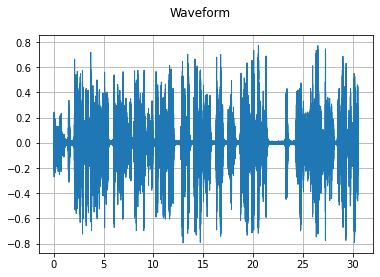

In [8]:
longest_wav, sr = torchaudio.load(longest_file_path)
H.plot_waveform(longest_wav, sr)

In [9]:
H.play_audio(longest_wav, sr)

In [10]:
# how many are less than 15 seconds 
over_15_sec = len(ASVP_metadata) - len(ASVP_metadata[ASVP_metadata['Duration'] <= 15])
print(f"There are {over_15_sec} rows over 15 seconds")

There are 44 rows over 15 seconds


In [11]:
# how many are less than 15 seconds 
over_10_sec = len(ASVP_metadata) - len(ASVP_metadata[ASVP_metadata['Duration'] <= 10])
print(f"There are {over_10_sec} rows over 10 seconds")

There are 534 rows over 10 seconds


# New DataFrame 
lets decide how long are samples should be but lets look how much it effects the classes 

In [12]:
df_20s = ASVP_metadata[ASVP_metadata['Duration'] <= 20]
df_15s = ASVP_metadata[ASVP_metadata['Duration'] <= 15]
df_10s = ASVP_metadata[ASVP_metadata['Duration'] <= 10]


print(f'Length of dataframe (20 seconds): {len(df_20s)} rows')
print(f'Length of dataframe (15 seconds): {len(df_15s)} rows')
print(f'Length of dataframe (10 seconds): {len(df_10s)} rows')

Length of dataframe (20 seconds): 3929 rows
Length of dataframe (15 seconds): 3902 rows
Length of dataframe (10 seconds): 3412 rows


In [13]:
df_20s['Emotions'].value_counts()

neutral           1013
angry              984
happy              495
sad                470
surprised          327
disappointment     234
fearful            137
disgust             93
excited             92
pain                36
boredom             26
pleasure            22
Name: Emotions, dtype: int64

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


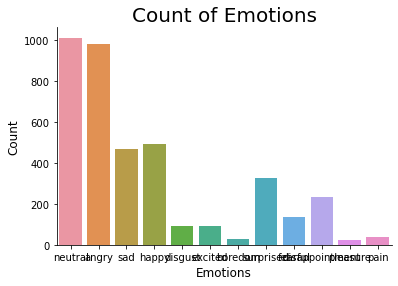

<Figure size 1440x4032 with 0 Axes>

In [14]:
plt.title('Count of Emotions', size=20)
sns.countplot(df_20s.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.figure(figsize=(20,56))
plt.show()

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


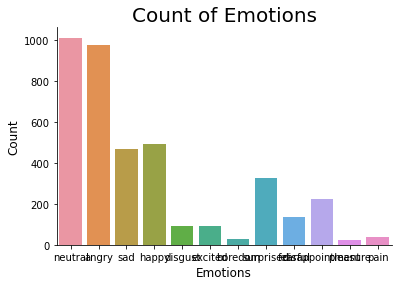

<Figure size 1440x4032 with 0 Axes>

In [15]:
plt.title('Count of Emotions', size=20)
sns.countplot(df_15s.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.figure(figsize=(20,56))
plt.show()

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


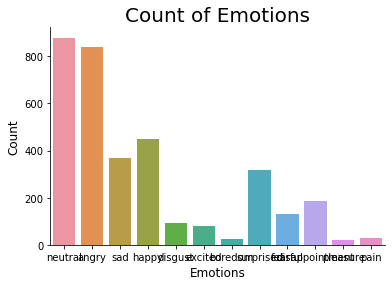

<Figure size 1440x4032 with 0 Axes>

In [16]:
plt.title('Count of Emotions', size=20)
sns.countplot(df_10s.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.figure(figsize=(20,56))
plt.show()

So lets go with the 10 second dataframe. It will contain the Path's for all the files that are 10 seconds or less. 

In [17]:
df_10s.describe()

,Sample_Rate,Num_Frames,Duration
count,3412.0,3412.000000,3412.000000
mean,16000.0,86303.577960,5.393974
std,0.0,45523.020818,2.845189
min,16000.0,6069.000000,0.379312
25%,16000.0,46271.250000,2.891953
50%,16000.0,81920.000000,5.120000
75%,16000.0,126643.000000,7.915188
max,16000.0,160000.000000,10.000000


In [18]:
df_10s['Emotions'].value_counts()

neutral           879
angry             840
happy             447
sad               369
surprised         318
disappointment    185
fearful           130
disgust            93
excited            78
pain               27
boredom            25
pleasure           21
Name: Emotions, dtype: int64

In [19]:
# Global Variables 

SAMPLE_RATE = 16000
N_FFT = int(0.025 * SAMPLE_RATE)   # 25 ms 
HOP_LENGTH = int(0.01 * SAMPLE_RATE)  # 10 ms
DURATION = 10
N_SAMPLES = SAMPLE_RATE * DURATION 

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"



In [20]:
audio_dataset = ASVPDataset(
    annotations_file=df_10s, 
    audio_dir=ASVP_dir,
    target_sample_rate=SAMPLE_RATE, 
    num_samples=N_SAMPLES,
    device=device  
)

In [21]:
len(audio_dataset)

3412

In [22]:
audio_dataset[133]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 'pain')

# Data Preprossing 

not that we are able to locate our data properly we'll create a custom Dataset object with Pytorch. This will make it easier to work with 

In [23]:
test_sample, test_label = audio_dataset[1000]
print(test_label, test_sample)

angry tensor([[ 0.0000e+00,  0.0000e+00, -3.0518e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


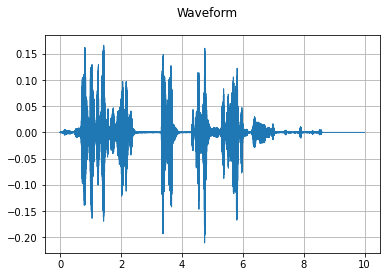

In [24]:

plot_waveform(test_sample, 16000)



In [25]:
print_stats(test_sample, sample_rate=SAMPLE_RATE)

Sample Rate: 16000
Shape: (1, 160000)
Dtype: torch.float32
 - Max:      0.166
 - Min:     -0.211
 - Mean:     0.000
 - Std Dev:  0.019

tensor([[ 0.0000e+00,  0.0000e+00, -3.0518e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])



Shape: (1, 513, 313)
Dtype: torch.float32
 - Max:     606.000
 - Min:      0.000
 - Mean:     0.144
 - Std Dev:  3.805

tensor([[[4.4415e-06, 6.6241e-05, 8.4669e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.9775e-06, 2.7469e-05, 3.5764e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [8.3762e-05, 4.6675e-05, 3.4997e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [6.0733e-07, 4.4747e-08, 9.3873e-08,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.7282e-07, 6.4856e-08, 3.2836e-07,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.9047e-07, 6.8824e-09, 3.5423e-07,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]])



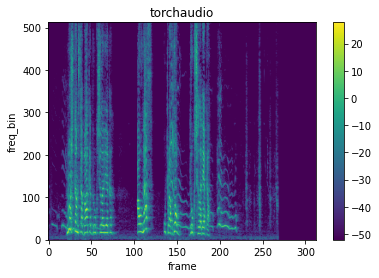

In [26]:
n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(test_sample)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')


# Split data into Train, Test and Validation sets 

In [27]:
total_count = len(audio_dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
print('Train count: ' + str(train_count))
print('validation count: ' + str(valid_count))
print('Test count: ' + str(test_count))

Train count: 2388
validation count: 682
Test count: 342


In [28]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(audio_dataset, (train_count, valid_count, test_count))

In [29]:
labels = sorted(list(set(r[1] for r in train_dataset)))
labels


['angry',
 'boredom',
 'disappointment',
 'disgust',
 'excited',
 'fearful',
 'happy',
 'neutral',
 'pain',
 'pleasure',
 'sad',
 'surprised']

In [30]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [31]:
word_start = "neutral"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

neutral --> tensor(7) --> neutral


In [32]:
type(index)


torch.Tensor

In [33]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=16000, new_freq=new_sample_rate)
transformed = transform(test_sample)

In [34]:
one_hot = torch.nn.functional.one_hot(index, 12)
one_hot

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [35]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 256
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [49]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)

In [37]:
train_loader

In [38]:
len(labels)

12

# Model 

In [39]:
# M5 model described in the following paper: 
# https://arxiv.org/pdf/1610.00087.pdf

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=len(labels), stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [40]:
model = M5(n_input=test_sample.shape[0], n_output=len(labels))
model.to(device)
print(model)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=12, bias=True)
)


In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 25420


In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

# train net

In [57]:

def train(model, epoch, log_interval):
    model.train()
    right = 0
    for batch_index, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # print training stats
        if batch_index % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_index * len(data)}/{len(train_loader.dataset)} ({100. * batch_index / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\tAccuracy: {right}/{len(train_loader.dataset)} ({100. * right / len(train_loader.dataset):.0f}%)")
  
        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses_train.append(loss.item())

    acc = 100. * (right/len(train_loader.dataset))
    accuracy_train.append(acc)

In [ ]:
def nr_of_right(pred, target):
    # count nr of right predictions
    return pred.squeeze().eq(target).sum().item()


def get_probable_idx(tensor):
    # find most probable wordclass index for each element in the batch
    return tensor.argmax(dim=-1)

In [58]:
def validate(model, epoch):
    #Stop training
    model.eval()
    
    right = 0
    for data, target in validation_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nValidation Epoch: {epoch} \tLoss: {loss.item():.6f}\tAccuracy: {right}/{len(validation_loader.dataset)} ({100. * right / len(validation_loader.dataset):.0f}%)\n")
     
    acc = 100. * right / len(validation_loader.dataset)
    accuracy_validation.append(acc)
    losses_validation.append(loss.item())





def test(model):
    #Stop training
    model.eval()
    
    right = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)

    print(f"\nTest set accuracy: {right}/{len(test_loader.dataset)} ({100. * right / len(test_loader.dataset):.0f}%)\n")

    return (100. * right / len(test_loader.dataset))

In [62]:
log_interval = 20
n_epoch = 5

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

losses = []
# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        validate(model, epoch)
        scheduler.step()

  2%|▏         | 0.08333333333333333/5 [00:03<03:32, 43.20s/it]

Train Epoch: 1 [0/2388 (0%)]	Loss: 1.389078	Accuracy: 133/2388 (6%)


 17%|█▋        | 0.8333333333333334/5 [00:34<02:50, 40.86s/it] 


NameError: name 'get_probable_idx' is not defined

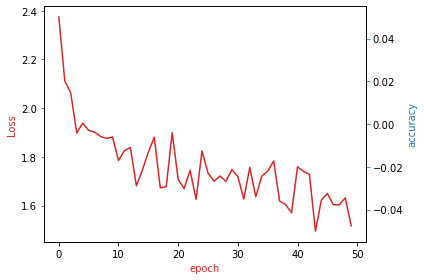

In [ ]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(losses, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()


# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()



In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, label = train_dataset[-1]
#ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {label}. Predicted: {predict(waveform)}.")

Expected: happy. Predicted: neutral.


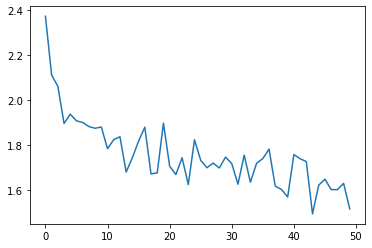

In [ ]:
plt.plot(losses)